##  Gridded Model Verification

This script verifies output from a ML-based foundation model versus a
traditional NWP system for the atmospheric system. The defaults set at the top of
this script are tailored to the Alps-Clariden HPC system at CSCS.
- The NWP-model is called COSMO-E and is initialised with the ensemble mean of the analysis. Only surface level data is available in the archive at MeteoSwiss.
- The ML-model is called Neural-LAM and is initialised with the deterministic analysis.
- The Ground Truth is the same deterministic analysis as was used to train the ML-model.
- The boundary data for both models is IFS HRES from ECMWF, where the NWP-model got 6 hourly boundary updates and the ML model 12 hourly.

For more info about the COSMO model see:
- https://www.cosmo-model.org/content/model/cosmo/coreDocumentation/cosmo_io_guide_6.00.pdf
- https://www.research-collection.ethz.ch/handle/20.500.11850/720460

In [ ]:
import random
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
import matplotlib.pyplot as plt
from dask.distributed import LocalCluster, Client
import numpy as np
from dask.diagnostics import ProgressBar
import pandas as pd
import xarray as xr
from pysteps.verification.salscores import sal  # requires scikit-image
from scipy.stats import kurtosis, skew, wasserstein_distance
from scores.categorical import ThresholdEventOperator as TEO
from scores.continuous import (
    mae,
    mean_error,
    mse,
    rmse,
)
from scores.continuous.correlation import pearsonr
from scores.spatial import fss_2d

**--------> Enter all your user settings in the cell below. <--------**

In [ ]:
### DEFAULTS ###
# This config will be applied to the data before any plotting. The data will be
# sliced and indexed according to the values in this config.The whole analysis and
# plotting will be done on the reduced data.

# IF YOUR DATA HAS DIFFERENT DIMENSIONS OR NAMES, PLEASE ADJUST THE CELLS BELOW
# MAKE SURE THE XARRAY DATASETS LOOK OKAY BEFORE RUNNING CHAPTER 1-4

# This path should point to the data that was used to train the model (default is mdp-datastore)
PATH_GROUND_TRUTH = "neural-lam/cosmo.datastore.zarr"
# This path should point to the NWP forecast data in zarr format
PATH_NWP = "cosmo_e_forecast.zarr"
# This path should point to the ML forecast data in zarr format (e.g. produced by neural-lam in `eval` mode)
PATH_ML = "preds_7_19_margin_interior_lr_0001_ar_12.zarr"
# This path should point to the boundary data in zarr format (default is MDP-datastore)
PATH_BOUNDARY = "ifs_7_19_margin_interior.datastore.zarr"

# elapsed forecast duration in steps for the forecast - [0] refers to the first forecast step at t+1
# this should be a list of integers
ELAPSED_FORECAST_DURATION = [0, 23, 47, 71, 95, 119]
#ELAPSED_FORECAST_DURATION = list(range(119))

# Select specific start_times for the forecast. This is the start and end of
# a slice in xarray. The start_time is included, the end_time is excluded.
# This should be a list of two strings in the format "YYYY-MM-DDTHH:MM:SS"
# Should be handy to evaluate certain dates, e.g. for a case study of a storm
START_TIMES = ["2019-10-31T00:00:00", "2020-10-23T13:00:00"]  # Full year
# START_TIMES = ["2020-02-08T00:00:00", "2020-02-15T00:00:00"]  # Ciara/Sabine

# Select specific plot times for the forecast (will be used to create maps for all variables)
# This only affect chapter one with the plotting of the maps
# Map creation takes a lot of time so this is limited to a single time step
# Simply rerun these cells and chapter one for more time steps
PLOT_TIME = "2020-02-07T00:00:00"

# Selection spatial grid in projection
# This is used to slice the data to a specific region
# This is in projection of the ground truth data
# The default is the whole domain [None, None]
X = [None, None]
Y = [None, None]

# Map projection settings for plotting
# This is the projection of the ground truth data
PROJECTION = ccrs.RotatedPole(
    pole_longitude=190,
    pole_latitude=43,
    central_rotated_longitude=10,
)

# Define how variables map between different data sources

# Define here which of the variables are available in the ground truth data
# The keys are the names of the variables in the ground truth data
# The values are the conventional names, used in this notebook
VARIABLES_GROUND_TRUTH = {
    # Surface and near-surface variables
    "T_2M": "temperature_2m",
    "U_10M": "wind_u_10m",
    "V_10M": "wind_v_10m",
    # "PMSL": "pressure_sea_level",
    "PS": "surface_pressure",
    "TOT_PREC": "precipitation",
    # "ASHFL_S": "surface_sensible_heat_flux",
    # "ASOB_S": "surface_net_shortwave_radiation",
    # "ATHB_S": "surface_net_longwave_radiation",
    # # Upper air variables - U component
    # "U_lev_6": "wind_u_level_6",
    # "U_lev_12": "wind_u_level_12",
    # "U_lev_20": "wind_u_level_20",
    # "U_lev_27": "wind_u_level_27",
    # "U_lev_31": "wind_u_level_31",
    # "U_lev_39": "wind_u_level_39",
    # "U_lev_45": "wind_u_level_45",
    # "U_lev_60": "wind_u_level_60",
    # # Upper air variables - V component
    # "V_lev_6": "wind_v_level_6",
    # "V_lev_12": "wind_v_level_12",
    # "V_lev_20": "wind_v_level_20",
    # "V_lev_27": "wind_v_level_27",
    # "V_lev_31": "wind_v_level_31",
    # "V_lev_39": "wind_v_level_39",
    # "V_lev_45": "wind_v_level_45",
    # "V_lev_60": "wind_v_level_60",
    # # Upper air variables - Pressure
    # "PP_lev_6": "pressure_level_6",
    # "PP_lev_12": "pressure_level_12",
    # "PP_lev_20": "pressure_level_20",
    # "PP_lev_27": "pressure_level_27",
    # "PP_lev_31": "pressure_level_31",
    # "PP_lev_39": "pressure_level_39",
    # "PP_lev_45": "pressure_level_45",
    # "PP_lev_60": "pressure_level_60",
    # # Upper air variables - Temperature
    # "T_lev_6": "temperature_level_6",
    # "T_lev_12": "temperature_level_12",
    # "T_lev_20": "temperature_level_20",
    # "T_lev_27": "temperature_level_27",
    # "T_lev_31": "temperature_level_31",
    # "T_lev_39": "temperature_level_39",
    # "T_lev_45": "temperature_level_45",
    # "T_lev_60": "temperature_level_60",
    # # Upper air variables - Relative Humidity
    # "RELHUM_lev_6": "relative_humidity_level_6",
    # "RELHUM_lev_12": "relative_humidity_level_12",
    # "RELHUM_lev_20": "relative_humidity_level_20",
    # "RELHUM_lev_27": "relative_humidity_level_27",
    # "RELHUM_lev_31": "relative_humidity_level_31",
    # "RELHUM_lev_39": "relative_humidity_level_39",
    # "RELHUM_lev_45": "relative_humidity_level_45",
    # "RELHUM_lev_60": "relative_humidity_level_60",
    # # Upper air variables - Vertical velocity
    # "W_lev_6": "vertical_velocity_level_6",
    # "W_lev_12": "vertical_velocity_level_12",
    # "W_lev_20": "vertical_velocity_level_20",
    # "W_lev_27": "vertical_velocity_level_27",
    # "W_lev_31": "vertical_velocity_level_31",
    # "W_lev_39": "vertical_velocity_level_39",
    # "W_lev_45": "vertical_velocity_level_45",
    # "W_lev_60": "vertical_velocity_level_60",
}

# Since the default ground_truth is the datastore that was used for model training
# the variables are identical to the VARIABLES_GROUND_TRUTH
VARIABLES_ML = VARIABLES_GROUND_TRUTH

# For the NWP-Forecast only a limited set of variables is available
# These variables are mapped to the same conventional names
# The script is flexible and will only calculate the NWP-metrics for the variables that are available
# The script will not break if some of the variables are not available
VARIABLES_NWP = {
    "wind_u_10m": "wind_u_10m",
    "wind_v_10m": "wind_v_10m",
    "precipitation_1hr": "precipitation",
    #"pressure_sea_level": "pressure_sea_level",
    "surface_pressure": "surface_pressure",
    "temperature_2m": "temperature_2m",
}

# These variables are only used for chapter 1, the mapplots.
# They will be plotted for the ground truth, NWP and ML
VARIABLES_BOUNDARY = {
    # Surface and near-surface variables
    "mean_sea_level_pressure": "pressure_sea_level",
    "2m_temperature": "temperature_2m",
    "10m_u_component_of_wind": "wind_u_10m",
    "10m_v_component_of_wind": "wind_v_10m",
    "surface_pressure": "surface_pressure",
    # Upper air variables - U component
    "u_component_of_wind100hPa": "wind_u_level_6",
    "u_component_of_wind200hPa": "wind_u_level_12",
    "u_component_of_wind400hPa": "wind_u_level_20",
    "u_component_of_wind600hPa": "wind_u_level_27",
    "u_component_of_wind700hPa": "wind_u_level_31",
    "u_component_of_wind850hPa": "wind_u_level_39",
    "u_component_of_wind925hPa": "wind_u_level_45",
    "u_component_of_wind1000hPa": "wind_u_level_60",
    # Upper air variables - V component
    "v_component_of_wind100hPa": "wind_v_level_6",
    "v_component_of_wind200hPa": "wind_v_level_12",
    "v_component_of_wind400hPa": "wind_v_level_20",
    "v_component_of_wind600hPa": "wind_v_level_27",
    "v_component_of_wind700hPa": "wind_v_level_31",
    "v_component_of_wind850hPa": "wind_v_level_39",
    "v_component_of_wind925hPa": "wind_v_level_45",
    "v_component_of_wind1000hPa": "wind_v_level_60",
    # Upper air variables - Temperature
    "temperature100hPa": "temperature_level_6",
    "temperature200hPa": "temperature_level_12",
    "temperature400hPa": "temperature_level_20",
    "temperature600hPa": "temperature_level_27",
    "temperature700hPa": "temperature_level_31",
    "temperature850hPa": "temperature_level_39",
    "temperature925hPa": "temperature_level_45",
    "temperature1000hPa": "temperature_level_60",
    # Upper air variables - Vertical velocity
    "vertical_velocity100hPa": "vertical_velocity_level_6",
    "vertical_velocity200hPa": "vertical_velocity_level_12",
    "vertical_velocity400hPa": "vertical_velocity_level_20",
    "vertical_velocity600hPa": "vertical_velocity_level_27",
    "vertical_velocity700hPa": "vertical_velocity_level_31",
    "vertical_velocity850hPa": "vertical_velocity_level_39",
    "vertical_velocity925hPa": "vertical_velocity_level_45",
    "vertical_velocity1000hPa": "vertical_velocity_level_60",
}

# These variables will be used as `basename` for the vertical profiles.
# Since the input of the zarr archives is expected to have data vars that are 2D in space
# we need some base_name prefix to create the 3D variables
VARIABLES_3D = [
    "temperature_level",
    "wind_u_level",
    "wind_v_level",
    "pressure_level",
    "relative_humidity_level",
    "vertical_velocity_level",
]

# Add units dictionary after the imports
# units from zarr archives are not reliable and should rather be defined here
VARIABLE_UNITS = {
    # Surface and near-surface variables
    "temperature_2m": "K",
    "wind_u_10m": "m/s",
    "wind_v_10m": "m/s",
    "pressure_sea_level": "Pa",
    "surface_pressure": "Pa",
    "precipitation": "mm/h",
    "surface_sensible_heat_flux": "W/m²",
    "surface_net_shortwave_radiation": "W/m²",
    "surface_net_longwave_radiation": "W/m²",
    # Upper air variables
    "temperature_level": "K",
    "wind_u_level": "m/s",
    "wind_v_level": "m/s",
    "pressure_level": "Pa",
    "relative_humidity_level": "%",
    "vertical_velocity_level": "Pa/s",
}

# Define Thresholds for the ETS metric (Equitable Threat Score)
# These are calculated for wind and precipitation if available
# The score creates contingency tables for different thresholds
# The ETS is calculated for each threshold and the results are plotted
# The default thresholds are [0.1, 1, 5] for precipitation and [2.5, 5, 10] for wind
THRESHOLDS_PRECIPITATION = [0.1, 1, 5]  # mm/h
THRESHOLDS_WIND = [2.5, 5, 10]  # m/s

# Define the metrics to compute for the verification
# Some additional verifications will always be computed if the repsective vars
# are available in the data
METRICS = [
    # "MAE",
    "RMSE",
    # "MSE",
    # "ME",
    # "STDEV_ERR",
    # "RelativeMAE",
    # "RelativeRMSE",
    # "PearsonR",
    # "Wasserstein",
    #"FSS"
]

# This setting is relevant for the mapplots in chapter 1
# Higher levels of ZOOM will zoom in on the map, cropping the boundary
ZOOM = 2  # Halves the extent of the mapplot

# For some chapters a random seed is required to reproduce the results
RANDOM_SEED = 42

# The DPI used in all plots in the notebook, export to pdf will always be 300 DPI
DPI = 100

# Subsample the data for faster plotting, 0.1 refers to 10% of the ml/nwp data
# sampled along the start_time, dimensions.
#
# The wasserstein metric and the SAL metric don't support lazy dask loading
# and can overflow memory without subsampling.
#
# By default all metrics/plots calculations are subsampled to speed up the process.
#
# There is a trade-off between speed and accuracy, that each user has to find.
SUBSAMPLE_FRACTION = 1.0

# If the data should be loaded into memory. Makes following calculations faster
# but requires enough memory to hold the data.
PRECOMPUTE_DATA = True

# Takes a long time, but if you see NaN in your output, you can set this to True
# This will check if there are any missing values in the data further below
# THIS NOTEBOOK WILL ONLY WORK RELIABLY IF THERE ARE NO MISSING VALUES
# If there are missing values, you have to interpolate them or remove them
CHECK_MISSING = False

# Font sizes for consistent plotting (different fig-sizes wil require different font sizes)
FONT_SIZES = {
    "axes": 24,  # Axis labels and titles
    "ticks": 24,  # Tick labels
    "legend": 22,  # Legend text
    "cbar": 24,  # Colorbar labels
    "suptitle": 24,  # Figure suptitle
    "title": 24,  # Axes titles
    "stats": 22,  # Statistics text in plots
}


In [ ]:
# Create directories for plots and tables
Path("plots").mkdir(exist_ok=True)
Path("tables").mkdir(exist_ok=True)

# Colorblind-friendly color palette
COLORS = {
    "gt": "#000000",  # Black
    "ml": "#E69F00",  # Orange
    "nwp": "#56B4E9",  # Light blue
    "per": "#CC79A7",  # Pink
}

# Line styles and markers for accessibility
LINE_STYLES = {
    "gt": ("solid", "o"),
    "ml": ("dashed", "s"),
    "nwp": ("dotted", "^"),
    "per": ("dashdot", "v"),
}

# Set global font sizes
plt.rcParams.update({
    "font.size": FONT_SIZES["axes"],
    "axes.titlesize": FONT_SIZES["axes"],
    "axes.labelsize": FONT_SIZES["axes"],
    "xtick.labelsize": FONT_SIZES["ticks"],
    "ytick.labelsize": FONT_SIZES["ticks"],
    "legend.fontsize": FONT_SIZES["legend"],
    "figure.titlesize": FONT_SIZES["suptitle"],
})

# Colorblind-friendly colormap for 2D plots
COLORMAP = "viridis"

# Add level-specific units by reusing base units
required_levels = {
    int(key.split("_")[-1]) for key in VARIABLES_GROUND_TRUTH if "lev_" in key
}

# First, collect all the base variables and units we need to extend
base_level_vars = {}
for base_var, unit in VARIABLE_UNITS.items():
    if "_level" in base_var:
        base_level_vars[base_var] = unit

# Then create the level-specific entries
for level in required_levels:
    for base_var, unit in base_level_vars.items():
        VARIABLE_UNITS[f"{base_var}_{level}"] = unit


def save_plot(fig, name, time=None, remove_title=True, dpi=300):
    """Helper function to save plots consistently

    Args:
        fig: matplotlib figure object
        name (str): base name for the plot file
        time (datetime, optional): timestamp to append to filename
        remove_title (bool): remove suptitle/title hierarchically if True
        dpi (int): resolution for the saved figure, defaults to 300
    """
    if time is not None:
        name = f"{name}_{time.dt.strftime('%Y%m%d_%H').values}"

    # Sanitize filename by replacing problematic characters
    safe_name = name.replace("/", "_per_")

    # Normalize the path and ensure plots directory exists
    plot_dir = Path("plots")
    plot_dir.mkdir(exist_ok=True)

    # Remove titles if requested
    if remove_title:
        if hasattr(fig, "texts") and fig.texts:  # Check for suptitle
            fig.suptitle("")
        ax = fig.gca()
        if ax.get_title():
            ax.set_title("")

    pdf_path = plot_dir / f"{safe_name}.pdf"
    fig.savefig(pdf_path, bbox_inches="tight", dpi=dpi)


def export_table(df, name, caption=""):
    """Helper function to export tables consistently"""
    # Export to LaTeX with caption
    latex_str = df.to_latex(
        float_format="%.4f", caption=caption, label=f"tab:{name}"
    )
    with open(f"tables/{name}.tex", "w") as f:
        f.write(latex_str)

    # Export to CSV
    df.to_csv(f"tables/{name}.csv")

In [ ]:
ds_ml = xr.open_zarr(PATH_ML)
ds_ml = ds_ml.sel(state_feature=list(VARIABLES_ML.keys()))
ds_ml = ds_ml.sel(y=slice(*Y), x=slice(*X))
ds_ml = ds_ml.sel(start_time=slice(*START_TIMES))
for feature in ds_ml.state_feature.values:
    ds_ml[VARIABLES_ML[feature]] = ds_ml["state"].sel(state_feature=feature)
forecast_times = (
    ds_ml.start_time.values[:, None] + ds_ml.elapsed_forecast_duration.values
)
ds_ml = ds_ml.assign_coords(
    forecast_time=(
        ("start_time", "elapsed_forecast_duration"),
        forecast_times,
    )
)
ds_ml = ds_ml.drop_vars(["state", "state_feature", "time"])
ds_ml = ds_ml.transpose("start_time", "elapsed_forecast_duration", "x", "y")
ds_ml = ds_ml[
    [
        "start_time",
        "elapsed_forecast_duration",
        "x",
        "y",
        *VARIABLES_ML.values(),
    ]
]
ds_ml = ds_ml.isel(elapsed_forecast_duration=ELAPSED_FORECAST_DURATION)

ds_ml

In [ ]:
ds_gt = xr.open_zarr(PATH_GROUND_TRUTH)
ds_gt = ds_gt.set_index(grid_index=["y", "x"]).unstack("grid_index")
ds_gt = ds_gt.sel(y=slice(*Y), x=slice(*X))
ds_gt = ds_gt.sel(state_feature=list(VARIABLES_ML.keys()))
ds_gt = ds_gt.sel(split_name="test").drop_dims([
    "forcing_feature",
    "static_feature",
    "split_part",
])
for feature in ds_gt.state_feature.values:
    ds_gt[VARIABLES_ML[feature]] = ds_gt["state"].sel(state_feature=feature)
ds_gt = ds_gt.drop_vars([
    "state",
    "state_feature",
    "state_feature_units",
    "state_feature_long_name",
    "state_feature_source_dataset",
    "state__train__diff_mean",
    "state__train__diff_std",
    "state__train__mean",
    "state__train__std",
])
ds_gt = ds_gt.transpose("time", "x", "y")
ds_gt = ds_gt[
    [
        "time",
        "x",
        "y",
        *VARIABLES_GROUND_TRUTH.values(),
    ]
]
time_subset = np.concatenate((ds_ml.forecast_time.values.flatten(), ds_ml.start_time.values.flatten()))
ds_gt = ds_gt.sel(time=np.unique(time_subset))
ds_gt


In [ ]:
zarr_path = (
    "/capstor/store/cscs/swissai/a01/sadamov/cosmo_e_forecast_fixed.zarr"
)
if not Path(zarr_path).exists():
    ds_nwp = xr.open_zarr(PATH_NWP)
    ds_nwp = ds_nwp.sel(y=slice(*Y), x=slice(*X), time=slice(*START_TIMES))
    ds_nwp = ds_nwp[VARIABLES_NWP.keys()].rename(VARIABLES_NWP)
    ds_nwp = ds_nwp.rename_dims({
        "lead_time": "elapsed_forecast_duration",
        "time": "start_time",
    })
    ds_nwp = ds_nwp.rename_vars({
        "lead_time": "elapsed_forecast_duration",
        "time": "start_time",
    })
    forecast_times = (
        ds_nwp.start_time.values[:, None]
        + ds_nwp.elapsed_forecast_duration.values
    )
    ds_nwp = ds_nwp.assign_coords(
        forecast_time=(
            ("start_time", "elapsed_forecast_duration"),
            forecast_times,
        )
    )

    # # Calculate hourly values by taking differences along elapsed_forecast_duration
    ds_nwp["precipitation"] = ds_nwp.precipitation.diff(
        dim="elapsed_forecast_duration"
    )
    # The NWP data starts at elapsed forecast duration 0 = start_time
    ds_nwp = ds_nwp.drop_isel(elapsed_forecast_duration=0).isel(
        elapsed_forecast_duration=ELAPSED_FORECAST_DURATION
    )

    ds_nwp = ds_nwp.transpose(
        "start_time", "elapsed_forecast_duration", "x", "y"
    )
    ds_nwp = ds_nwp[
        [
            "start_time",
            "elapsed_forecast_duration",
            "x",
            "y",
            *VARIABLES_NWP.values(),
        ]
    ]
    chunks = {
        "start_time": 1,
        "elapsed_forecast_duration": 1,
        "x": -1,  # or ds_nwp.sizes["x"]
        "y": -1,  # or ds_nwp.sizes["y"]
    }

    # Create encoding dict for each variable
    encoding = {}
    for var in ds_nwp.data_vars:
        # Get the actual dimensions for this variable
        dims = ds_nwp[var].dims
        # Create chunks tuple matching the variable's dimensions
        var_chunks = tuple(chunks.get(dim, -1) for dim in dims)
        encoding[var] = {"chunks": var_chunks}

    # First ensure Dask chunks match
    ds_nwp_rechunked = ds_nwp.chunk(chunks)

    # Then write to Zarr with progress bar and encoding
    with ProgressBar():
        ds_nwp_rechunked.to_zarr(
            zarr_path, mode="w", consolidated=True, encoding=encoding
        )


ds_nwp = xr.open_zarr(zarr_path)
ds_nwp

Check for missing data in any of the variables. If you have missing data, you need to handle it before running the verification.

In [ ]:
if CHECK_MISSING:
    missing_counts = dask.compute(
        {var: ds_gt[var].isnull().sum().values for var in ds_gt.data_vars},
        {var: ds_nwp[var].isnull().sum().values for var in ds_nwp.data_vars},
        {var: ds_ml[var].isnull().sum().values for var in ds_ml.data_vars},
    )
    # Unpack results
    gt_missing, nwp_missing, ml_missing = missing_counts

    # Print results
    print("Ground Truth")
    for var, count in gt_missing.items():
        print(f"{var}: {count} missing values")

    print("\nNWP Model")
    for var, count in nwp_missing.items():
        print(f"{var}: {count} missing values")

    print("\nML Model")
    for var, count in ml_missing.items():
        print(f"{var}: {count} missing values")

In [ ]:
assert ds_gt.sizes["x"] == ds_ml.sizes["x"]
assert ds_gt.sizes["x"] == ds_nwp.sizes["x"]
assert ds_gt.sizes["y"] == ds_ml.sizes["y"]
assert ds_gt.sizes["y"] == ds_nwp.sizes["y"]
#assert ds_gt.sizes["time"] == len(
#    np.unique(ds_ml.forecast_time.values.flatten())
#)
#assert ds_gt.sizes["time"] == len(
#    np.unique(ds_nwp.forecast_time.values.flatten())
#)

# Generate random indices for each dimension
rng = np.random.RandomState(RANDOM_SEED)
sampled_start_time_indices = np.sort(
    rng.choice(
        len(ds_ml.start_time),
        size=int(len(ds_ml.start_time) * SUBSAMPLE_FRACTION),
        replace=False,
    )
)

# with (
#     LocalCluster(
#         n_workers=4,
#         threads_per_worker=16,
#         memory_limit="96GB",
#         local_directory="/iopsstor/scratch/cscs/sadamov",  # Use fast local storage for spilling
#         dashboard_address=None,
#     ) as cluster
# ):
#     with Client(cluster) as client:
ds_ml_sampled = ds_ml.isel(start_time=sampled_start_time_indices)
ds_nwp_sampled = ds_nwp.isel(start_time=sampled_start_time_indices)
ds_gt_sampled = ds_gt.sel(time=ds_ml_sampled.forecast_time)
if PRECOMPUTE_DATA:
    with ProgressBar():
        print("Computing ML data")
        ds_ml_sampled = ds_ml_sampled.compute()
        print("Computing NWP data")
        ds_nwp_sampled = ds_nwp_sampled.compute()
        print("Computing GT data")
        ds_gt_sampled = ds_gt_sampled.compute()


### 5. Various Verification Metrics
The final chapter consolidates various statistical metrics to provide a broad
evaluation of the ML model's performance. By considering multiple metrics, we
gain a nuanced understanding of both the strengths and weaknesses of the model.

**Metric Diversity:** Including MAE, RMSE, MSE, Pearson correlation, and the
Fractions Skill Score (FSS) covers different aspects of model performance, from
average errors to spatial pattern accuracy.

**ME** (Mean Error): Indicates the average discrepancy between the model and ground truth values. A positive value indicates that the model tends to overestimate, while a negative value suggests underestimation. Also called Bias.

**STDEV-ERR** (Standard Deviation of Errors): Shows the variability of errors, highlighting whether the model is consistent in its predictions.

**MAE, MSE and RMSE:** Offer insights into the average magnitude of errors, with
RMSE emphasizing larger discrepancies. The colors indicating high errors are
only implemented for these three metrics with standardization.

**Pearson Correlation:** Assesses the linear relationship, indicating whether
the model captures variability even if biases exist.

**FSS:** Evaluates spatial accuracy, which is particularly important for
predicting localized weather events.

**Wasserstein Distance:** Provides a holistic view of distributional similarity
across variables. Same as chapter 3.

**Holistic Assessment:** The combination of metrics provides a comprehensive
performance profile, essential for model validation and comparison. More complex metrics are explained in more detail.

#### Fractions Skill Score
Range: 0 to 1, where:
- 1 = perfect score
- 0 = no skill compared to random chance

**Key Properties:**
- FSS measures the spatial agreement between two fields, accounting for the spatial scale of the features
- It's particularly useful for assessing the spatial distribution of precipitation, cloud cover, or other fields with spatial structure
- FSS is sensitive to the threshold used to define the presence of a feature, so it's important to choose an appropriate threshold
- The FSS can be calculated for different spatial scales by defining the window size

**Advantages:**
- More meaningful than simple correlation for spatial fields
- Accounts for the spatial scale of features
- Provides a single value for the entire field comparison

In [ ]:
# These helper functions are only used to calculate the FSS threshold
max_spatial_dim = np.maximum(ds_gt.x.size, ds_gt.y.size)
window_size = (int(max_spatial_dim // 100),) * 2
n_points = int(
    np.minimum(
        1e7,
        ds_ml[list(VARIABLES_GROUND_TRUTH.values())[0]]
        .isel(elapsed_forecast_duration=0)
        .size,
    )
)
print(f"Using window size for FSS: {window_size}")
print(f"Using n_points for FSS: {n_points}")

In [ ]:
def calculate_metrics_by_efd(
    ds_gt,
    ds_ml,
    ds_nwp=None,
    metrics_to_compute=None,
    window_size=3,
    prefix="metrics",
):
    """Calculate metrics for each Elapsed Forecast Duration for gridded data."""
    if isinstance(window_size, (int, float)):
        window_size = (int(window_size), int(window_size))

    if metrics_to_compute is None:
        metrics_to_compute = METRICS

    variables = list(ds_gt.data_vars)
    elapsed_forecast_durations = ds_ml.elapsed_forecast_duration
    elapsed_forecast_durations_hours = elapsed_forecast_durations.values.astype(
        "timedelta64[s]"
    ) / np.timedelta64(1, "h")

    metrics_by_efd = {}
    combined_metrics = {}

    # Added persistence forecast
    per_fc = ds_gt.sel(time=ds_ml.start_time)

    for efd, lt_hours in zip(
        elapsed_forecast_durations, elapsed_forecast_durations_hours
    ):
        print(
            f"\nCalculating metrics for elapsed forecast duration: {lt_hours.item():.1f}h"
        )

        ds_ml_lead = ds_ml.sel(elapsed_forecast_duration=efd)
        if ds_nwp is not None:
            ds_nwp_lead = ds_nwp.sel(elapsed_forecast_duration=efd)

        forecast_times = ds_ml_lead.forecast_time
        ds_gt_lead = ds_gt.sel(time=forecast_times)
        metrics_dict = {}

        for var in variables:
            print(f"Processing {var}")

            # Get data as xarray DataArrays
            y_true = ds_gt_lead[var]
            y_pred_ml = ds_ml_lead[var]
            y_pred_per = per_fc[var]
            if ds_nwp is not None and var in ds_nwp_lead:
                y_pred_nwp = ds_nwp_lead[var]

            #quantile_90 = y_true.quantile(0.9).values
            #print("90th quantile for FSS threshold:", quantile_90)

            metrics_dict[var] = {}

            # Calculate ML metrics
            if "MAE" in metrics_to_compute:
                metrics_dict[var]["MAE ML"] = mae(y_pred_ml, y_true).values
            if "RMSE" in metrics_to_compute:
                metrics_dict[var]["RMSE ML"] = rmse(y_pred_ml, y_true).values
            if "MSE" in metrics_to_compute:
                metrics_dict[var]["MSE ML"] = mse(y_pred_ml, y_true).values
            if "ME" in metrics_to_compute:
                metrics_dict[var]["ME ML"] = mean_error(
                    y_pred_ml, y_true
                ).values
            if "STDEV_ERR" in metrics_to_compute:
                metrics_dict[var]["STDEV_ERR ML"] = (
                    (y_pred_ml - y_true).std().values
                )
            if "RelativeMAE" in metrics_to_compute:
                rel_mae = (
                    abs(y_pred_ml - y_true) / (abs(y_true) + 1e-6)
                ).mean()
                metrics_dict[var]["RelativeMAE ML"] = rel_mae.values
            if "RelativeRMSE" in metrics_to_compute:
                rel_rmse = np.sqrt(
                    ((y_pred_ml - y_true) ** 2 / (y_true**2 + 1e-6)).mean()
                )
                metrics_dict[var]["RelativeRMSE ML"] = rel_rmse.values
            if "PearsonR" in metrics_to_compute:
                metrics_dict[var]["PearsonR ML"] = pearsonr(
                    y_pred_ml, y_true
                ).values
            if "FSS" in metrics_to_compute:
                metrics_dict[var]["FSS ML"] = fss_2d(
                    y_pred_ml.compute(),
                    y_true.compute(),
                    event_threshold=quantile_90,
                    window_size=window_size,
                    spatial_dims=["y", "x"],
                ).values
            if "Wasserstein" in metrics_to_compute:
                pred_vals = y_pred_ml.values
                true_vals = y_true.values
                metrics_dict[var]["Wasserstein ML"] = wasserstein_distance(
                    pred_vals, true_vals
                )

            # Persistence
            if "RMSE" in metrics_to_compute:
                metrics_dict[var]["RMSE Persistence"] = rmse(y_pred_per, y_true).values

            # Calculate NWP metrics if available
            if ds_nwp is not None and var in ds_nwp:
                if "MAE" in metrics_to_compute:
                    metrics_dict[var]["MAE NWP"] = mae(
                        y_pred_nwp, y_true
                    ).values
                if "RMSE" in metrics_to_compute:
                    metrics_dict[var]["RMSE NWP"] = rmse(
                        y_pred_nwp, y_true
                    ).values
                if "MSE" in metrics_to_compute:
                    metrics_dict[var]["MSE NWP"] = mse(
                        y_pred_nwp, y_true
                    ).values
                if "ME" in metrics_to_compute:
                    metrics_dict[var]["ME NWP"] = mean_error(
                        y_pred_nwp, y_true
                    ).values
                if "STDEV_ERR" in metrics_to_compute:
                    metrics_dict[var]["STDEV_ERR NWP"] = (
                        (y_pred_nwp - y_true).std().values
                    )
                if "RelativeMAE" in metrics_to_compute:
                    rel_mae = (
                        abs(y_pred_nwp - y_true) / (abs(y_true) + 1e-6)
                    ).mean()
                    metrics_dict[var]["RelativeMAE NWP"] = rel_mae.values
                if "RelativeRMSE" in metrics_to_compute:
                    rel_rmse = np.sqrt(
                        ((y_pred_nwp - y_true) ** 2 / (y_true**2 + 1e-6)).mean()
                    )
                    metrics_dict[var]["RelativeRMSE NWP"] = rel_rmse.values
                if "PearsonR" in metrics_to_compute:
                    metrics_dict[var]["PearsonR NWP"] = pearsonr(
                        y_pred_nwp, y_true
                    ).values
                if "FSS" in metrics_to_compute:
                    metrics_dict[var]["FSS NWP"] = fss_2d(
                        y_pred_nwp.compute(),
                        y_true.compute(),
                        event_threshold=quantile_90,
                        window_size=window_size,
                        spatial_dims=["y", "x"],
                    ).values
                if "Wasserstein" in metrics_to_compute:
                    pred_vals = y_pred_nwp.values
                    true_vals = y_true.values
                    metrics_dict[var]["Wasserstein NWP"] = wasserstein_distance(
                        pred_vals, true_vals
                    )

            # Store combined metrics
            for metric_name, value in metrics_dict[var].items():
                key = f"{var}_{metric_name}"
                if key not in combined_metrics:
                    combined_metrics[key] = []
                combined_metrics[key].append(value)

        metrics_by_efd[lt_hours.item()] = pd.DataFrame.from_dict(
            metrics_dict, orient="index"
        )

    # Create combined metrics DataFrame
    elapsed_forecast_durations_hours_float = [
        x.item() for x in elapsed_forecast_durations_hours
    ]
    combined_df = pd.DataFrame(
        combined_metrics, index=elapsed_forecast_durations_hours_float
    )
    combined_df.index.name = "Forecast Hours"

    export_table(combined_df, f"{prefix}", "Combined metrics")

    return metrics_by_efd


In [ ]:
# with (
#     LocalCluster(
#         n_workers=1,
#         threads_per_worker=32,
#         memory_limit="48GB",
#         local_directory="/iopsstor/scratch/cscs/sadamov",  # Use fast local storage for spilling
#         dashboard_address=None,
#     ) as cluster
# ):
#     with Client(cluster) as client:
metrics_by_efd = calculate_metrics_by_efd(
    ds_gt=ds_gt,
    ds_ml=ds_ml_sampled,
    ds_nwp=ds_nwp_sampled,
    prefix="combined_metrics",
)
metrics_by_efd

In [ ]:
# Plot evolution of a specific metric over elapsed forecast duration
elapsed_forecast_durations = list(metrics_by_efd.keys())
for i, variable in enumerate(VARIABLES_GROUND_TRUTH.values()):
    for metric in METRICS:
        try:
            # Skip if any scores are missing
            ml_scores = [
                df.loc[variable, f"{metric} ML"]
                for df in metrics_by_efd.values()
            ]
            nwp_scores = [
                df.loc[variable, f"{metric} NWP"]
                for df in metrics_by_efd.values()
            ]

            # Convert elapsed forecast durations from hours to timedelta
            hours = [
                x / np.timedelta64(1, "h")
                for x in ds_ml.elapsed_forecast_duration.values
            ]

            fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

            # Plot ML scores
            ax.plot(
                hours,
                ml_scores,
                label="ML" if i == 0 else "",
                color=COLORS["ml"],
                linestyle=LINE_STYLES["ml"][0],
                marker=LINE_STYLES["ml"][1],
            )

            # Plot NWP scores if they exist and are not all NaN
            if not all(pd.isna(nwp_scores)):
                ax.plot(
                    hours,
                    nwp_scores,
                    label="NWP" if i == 0 else "",
                    color=COLORS["nwp"],
                    linestyle=LINE_STYLES["nwp"][0],
                    marker=LINE_STYLES["nwp"][1],
                )

            # Persistence
            per_metric_name = f"{metric} Persistence"
            per_scores = [
                df.loc[variable, per_metric_name]
                for df in metrics_by_efd.values() if per_metric_name in df
            ]

            # Plot persistence scores if they exist and are not all NaN
            if per_scores and not all(pd.isna(per_scores)):
                ax.plot(
                    hours,
                    per_scores,
                    label="Persistence" if i == 0 else "",
                    color=COLORS["per"],
                    linestyle=LINE_STYLES["per"][0],
                    marker=LINE_STYLES["per"][1],
                )

            ax.set_xlabel("Elapsed Forecast Duration (h)")
            ax.set_ylabel(f"{metric} ({VARIABLE_UNITS[variable]})")
            ax.set_title(f"{metric} Evolution for {variable}")
            ax.grid(True, alpha=0.3)

            # Only show legend for first variable
            if i == 0:
                ax.legend()

            plt.tight_layout()
            plt.show()
            save_plot(fig, f"{metric}_{variable}_evolution")
            plt.close()

        except (KeyError, ValueError) as e:
            print(f"Skipping {metric} for {variable}: {str(e)}")
            continue


#### Equitable Threat Score (Traditional Version)
Range: [-1/3, 1], where:
- 1 = perfect score
- 0 = no skill compared to random chance
- -1/3 = worst possible performance

**Key Properties:**
- Measures how well predicted events correspond to observed events, accounting for hits due to random chance
- Particularly useful for rare events (like precipitation above a high threshold)
- More equitable than simple Threat Score by accounting for hits due to random chance

**Advantages:**
- Well-established metric in meteorological verification
- Reference point at 0 makes interpretation clear
- Penalizes both misses and false alarms
- Accounts for random chance, making it more robust than basic threat scores

#### Frequency Bias Index
Range: 0 to infinity, where:
- 1 = no bias
- < 1 = underforecasting
- > 1 = overforecasting

**Key Properties:**
- FBI measures the ratio of observed to forecasted events, indicating whether the model tends to over- or underforecast
- It's particularly useful for understanding systematic biases in event frequency

**Advantages:**
- Provides a clear indication of over- or underforecasting
- Easy to interpret: 1 indicates no bias, while values above or below 1 show the direction and magnitude of the bias

In [ ]:
# Set display options for all float values
pd.set_option("display.float_format", lambda x: "{:.4f}".format(x))

In [ ]:
def calculate_meteoswiss_metrics(ds_gt, ds_ml, ds_nwp):
    """Calculate MeteoSwiss verification metrics"""
    metrics_by_var = {}

    # Get available variables in each dataset
    gt_ml_vars = set(ds_gt.variables) & set(ds_ml.variables)
    nwp_vars = set(ds_nwp.variables) if ds_nwp is not None else set()

    all_variables = {
        "precipitation": {
            "thresholds": THRESHOLDS_PRECIPITATION,
            "unit": "mm/h",
        },
        "wind_u_10m": {"thresholds": THRESHOLDS_WIND, "unit": "m/s"},
        "wind_v_10m": {"thresholds": THRESHOLDS_WIND, "unit": "m/s"},
    }

    # Filter variables that exist in gt and ml
    all_variables = {k: v for k, v in all_variables.items() if k in gt_ml_vars}

    # Initialize metrics structure
    for var_name in all_variables:
        metrics_by_var[var_name] = {}
        for thr in all_variables[var_name]["thresholds"]:
            metric_key = f"{thr}{all_variables[var_name]['unit']}"
            metrics_by_var[var_name][metric_key] = {
                "FBI_ML": [],
                "ETS_ML": [],
                "FBI_NWP": [] if ds_nwp is not None else None,
                "ETS_NWP": [] if ds_nwp is not None else None,
            }

    for efd in ds_ml.elapsed_forecast_duration.values:
        try:
            print(
                f"\nCalculating metrics for elapsed forecast duration: {efd / np.timedelta64(1, 'h'):.1f}h"
            )

            ds_ml_lead = ds_ml.sel(elapsed_forecast_duration=efd)
            ds_nwp_lead = (
                ds_nwp.sel(elapsed_forecast_duration=efd)
                if ds_nwp is not None
                else None
            )
            forecast_times = ds_ml_lead.forecast_time
            ds_gt_lead = ds_gt.sel(time=forecast_times)

            for var_name, var_config in all_variables.items():
                print(f"Processing {var_name}")
                try:
                    # Get data
                    y_true = ds_gt_lead[var_name]
                    y_ml = ds_ml_lead[var_name]
                    y_nwp = (
                        ds_nwp_lead[var_name]
                        if ds_nwp_lead is not None and var_name in nwp_vars
                        else None
                    )

                    for thr in var_config["thresholds"]:
                        metric_key = f"{thr}{var_config['unit']}"

                        # Calculate ML metrics using TEO
                        event_operator = TEO(default_event_threshold=thr)
                        ml_contingency = (
                            event_operator.make_contingency_manager(
                                y_ml, y_true
                            )
                        )

                        fbi_ml = ml_contingency.frequency_bias().values
                        ets_ml = ml_contingency.equitable_threat_score().values

                        metrics_by_var[var_name][metric_key]["FBI_ML"].append(
                            fbi_ml
                        )
                        metrics_by_var[var_name][metric_key]["ETS_ML"].append(
                            ets_ml
                        )

                        # Calculate NWP metrics if available
                        if y_nwp is not None:
                            nwp_contingency = (
                                event_operator.make_contingency_manager(
                                    y_nwp, y_true
                                )
                            )
                            fbi_nwp = nwp_contingency.frequency_bias().values
                            ets_nwp = (
                                nwp_contingency.equitable_threat_score().values
                            )

                            metrics_by_var[var_name][metric_key][
                                "FBI_NWP"
                            ].append(fbi_nwp)
                            metrics_by_var[var_name][metric_key][
                                "ETS_NWP"
                            ].append(ets_nwp)

                except Exception as e:
                    print(f"Error processing {var_name}: {str(e)}")
                    continue

        except Exception as e:
            print(f"Error processing elapsed forecast duration {efd}: {str(e)}")
            continue

    return metrics_by_var

def plot_metrics_evolution(
    metrics_by_var,
    elapsed_forecast_durations,
    var_name,
    metric_name,
    var_index=0,
):
    """Plot evolution of FBI/ETS metrics over elapsed forecast durations for gridded data."""
    try:
        if not metrics_by_var or var_name not in metrics_by_var:
            print(f"No metrics data available for {var_name}")
            return

        # Convert timedelta to hours for x-axis
        forecast_hours = [
            efd / np.timedelta64(1, "h") for efd in elapsed_forecast_durations
        ]

        # Get three fixed colors from viridis
        colors = [plt.cm.viridis(x) for x in [0, 0.5, 0.99]]

        fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

        # Plot for each threshold
        for i, (threshold, metrics) in enumerate(
            metrics_by_var[var_name].items()
        ):
            # Plot ML metrics
            if metrics["FBI_ML"]:  # Check if we have ML metrics
                ax.plot(
                    forecast_hours,
                    metrics[f"{metric_name}_ML"],
                    linestyle=LINE_STYLES["ml"][0],
                    marker=LINE_STYLES["ml"][1],
                    color=colors[i],
                    label=f"ML {threshold}" if var_index == 0 else "",
                )

            # Plot NWP metrics if available
            if metrics[f"{metric_name}_NWP"]:  # Check if we have NWP metrics
                ax.plot(
                    forecast_hours,
                    metrics[f"{metric_name}_NWP"],
                    linestyle=LINE_STYLES["nwp"][0],
                    marker=LINE_STYLES["nwp"][1],
                    color=colors[i],
                    label=f"NWP {threshold}" if var_index == 0 else "",
                )

        ax.set_xlabel("Elapsed Forecast Duration (h)")
        ax.set_ylabel(metric_name)
        ax.set_title(f"{metric_name} Evolution for {var_name}")
        ax.grid(True, alpha=0.3)

        # Only show legend for first variable
        if var_index == 0:
            ax.legend()

        plt.tight_layout()
        plt.show()
        save_plot(fig, f"{metric_name.lower()}_{var_name}_evolution")
        plt.close()

    except Exception as e:
        print(f"Error plotting {var_name} - {metric_name}: {str(e)}")

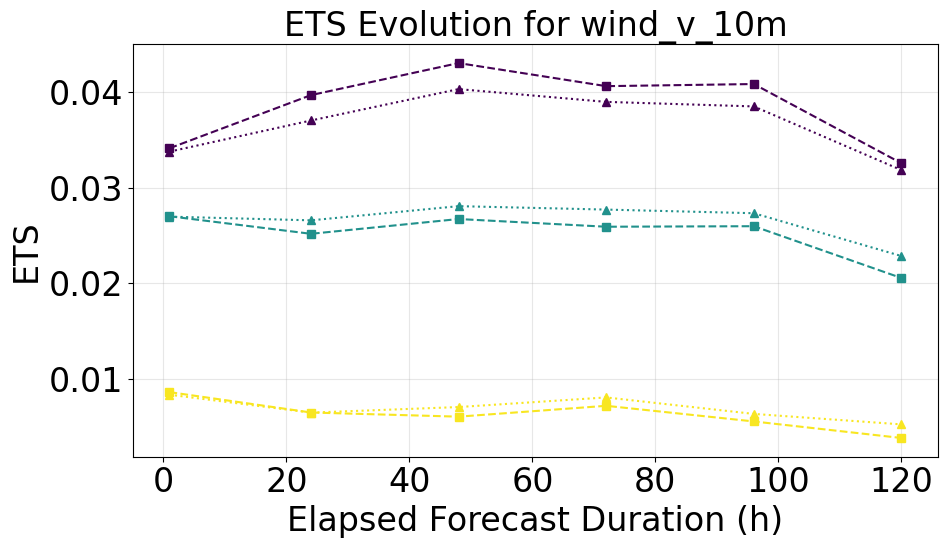

In [ ]:
def reshape_metrics_by_var(metrics_by_var, elapsed_forecast_durations):
    """Reshape the metrics dictionary into a DataFrame with thresholds as columns"""
    # Convert forecast durations to hours for index
    forecast_hours = [
        efd / np.timedelta64(1, "h") for efd in elapsed_forecast_durations
    ]

    # Create a list to store all data
    data = []

    # Iterate through each forecast hour
    for idx, hour in enumerate(forecast_hours):
        row_data = {"forecast_hour": hour}

        # Iterate through each variable and its thresholds
        for var_name, thresholds in metrics_by_var.items():
            for threshold, metrics in thresholds.items():
                # Add ML metrics if they exist and have values
                if metrics["FBI_ML"] is not None:
                    row_data[f"{var_name}_{threshold}_FBI_ML"] = metrics[
                        "FBI_ML"
                    ][idx]
                    row_data[f"{var_name}_{threshold}_ETS_ML"] = metrics[
                        "ETS_ML"
                    ][idx]

                # Add NWP metrics if they exist and have values
                if metrics["FBI_NWP"] is not None:
                    row_data[f"{var_name}_{threshold}_FBI_NWP"] = metrics[
                        "FBI_NWP"
                    ][idx]
                    row_data[f"{var_name}_{threshold}_ETS_NWP"] = metrics[
                        "ETS_NWP"
                    ][idx]

        data.append(row_data)

    # Create DataFrame from collected data
    df = pd.DataFrame(data)
    df.set_index("forecast_hour", inplace=True)
    return df


# Modify the main execution block:
try:
    print("Calculating MeteoSwiss metrics...")
    metrics_by_var = calculate_meteoswiss_metrics(ds_gt, ds_ml_sampled, ds_nwp_sampled)

    # Reshape and export metrics to table
    elapsed_forecast_durations = ds_ml.elapsed_forecast_duration.values
    metrics_df = reshape_metrics_by_var(
        metrics_by_var, elapsed_forecast_durations
    )

    export_table(
        metrics_df,
        "meteoswiss_metrics",
        "MeteoSwiss verification metrics (FBI and ETS)",
    )

    # Plot metrics for each variable
    for i, var_name in enumerate(metrics_by_var):
        for metric_name in ["FBI", "ETS"]:
            plot_metrics_evolution(
                metrics_by_var,
                elapsed_forecast_durations,
                var_name,
                metric_name,
                var_index=i
            )

except Exception as e:
    print(f"Error in main execution: {str(e)}")


The wind vector RMSE takes into account the magnitude and direction of the wind, providing a more comprehensive measure of error than scalar metrics.

In [ ]:
def wind_vector_rmse(u_pred, v_pred, u_true, v_true):
    """Calculate RMSE based on wind vector differences."""
    rmse_u = rmse(u_true, u_pred)
    rmse_v = rmse(v_true, v_pred)
    rmse_wind = np.sqrt(rmse_u**2 + rmse_v**2)
    return float(rmse_wind)


# Initialize results dictionary
results_wind = {"vector_metrics": {}}
elapsed_forecast_durations = ds_ml_sampled.elapsed_forecast_duration.values

# Lists to store RMSE values over time
ml_rmse_over_time = []
per_rmse_over_time = []
nwp_rmse_over_time = []
forecast_hours = [
    efd / np.timedelta64(1, "h") for efd in elapsed_forecast_durations
]

if "wind_u_10m" in ds_gt and "wind_v_10m" in ds_gt:

    # Persistence
    u_per = ds_gt["wind_u_10m"].sel(time=ds_ml_sampled.start_time)
    v_per = ds_gt["wind_v_10m"].sel(time=ds_ml_sampled.start_time)
    
    for efd in elapsed_forecast_durations:
        print(f"Calculating wind vector RMSE for EFD: {efd}")
        # Get corresponding forecast times
        forecast_times = ds_ml_sampled.sel(
            elapsed_forecast_duration=efd
        ).forecast_time

        # Get wind components for specific forecast time
        u_true = ds_gt["wind_u_10m"].sel(time=forecast_times)
        v_true = ds_gt["wind_v_10m"].sel(time=forecast_times)
        u_ml = ds_ml_sampled["wind_u_10m"].sel(elapsed_forecast_duration=efd)
        v_ml = ds_ml_sampled["wind_v_10m"].sel(elapsed_forecast_duration=efd)

        # Calculate ML RMSE
        wind_rmse_ml = wind_vector_rmse(u_ml, v_ml, u_true, v_true)
        ml_rmse_over_time.append(wind_rmse_ml)

        # Calculate Per RMSE
        wind_rmse_per = wind_vector_rmse(u_per, v_per, u_true, v_true)
        per_rmse_over_time.append(wind_rmse_per)

        # Calculate NWP RMSE if available
        if "wind_u_10m" in ds_nwp and "wind_v_10m" in ds_nwp:
            u_nwp = ds_nwp_sampled["wind_u_10m"].sel(elapsed_forecast_duration=efd)
            v_nwp = ds_nwp_sampled["wind_v_10m"].sel(elapsed_forecast_duration=efd)
            wind_rmse_nwp = wind_vector_rmse(u_nwp, v_nwp, u_true, v_true)
            nwp_rmse_over_time.append(wind_rmse_nwp)
        else:
            nwp_rmse_over_time.append(np.nan)

    # Create time series DataFrame
    time_series_df = pd.DataFrame({
        "Elapsed Forecast Duration": forecast_hours,
        "ML RMSE": ml_rmse_over_time,
        "Per RMSE": per_rmse_over_time,
        "NWP RMSE": nwp_rmse_over_time,
    })

    # Plot RMSE over time
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot ML model
    ax.plot(
        forecast_hours,
        ml_rmse_over_time,
        linestyle=LINE_STYLES["ml"][0],
        marker=LINE_STYLES["ml"][1],
        label="ML",
        color=COLORS["ml"],
    )

    # Plot Per model
    ax.plot(
        forecast_hours,
        per_rmse_over_time,
        linestyle=LINE_STYLES["per"][0],
        marker=LINE_STYLES["per"][1],
        label="Persistence",
        color=COLORS["per"],
    )

    # Plot NWP model if available
    if not all(np.isnan(nwp_rmse_over_time)):
        ax.plot(
            forecast_hours,
            nwp_rmse_over_time,
            linestyle=LINE_STYLES["nwp"][0],
            marker=LINE_STYLES["nwp"][1],
            label="NWP",
            color=COLORS["nwp"],
        )

    ax.set_xlabel("Elapsed Forecast Duration (h)")
    ax.set_ylabel("Wind Vector RMSE (m/s)")
    ax.set_title("Wind Vector RMSE Evolution")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    save_plot(fig, "wind_vector_rmse_evolution")

    export_table(
        time_series_df,
        "wind_vector_metrics_timeseries",
        caption="Wind vector RMSE over forecast duration",
    )
